Multivariate pattern analysis (MVPA)
===

# 0 Setup

In [10]:
from nilearn import plotting
import numpy as np
import nibabel as nb
from scipy.ndimage import binary_dilation
from nilearn.plotting import plot_roi
from nilearn import image
import os
import numpy as np
from scipy.signal import detrend
from scipy.stats import zscore
from matplotlib.pyplot import plot


fslpath = os.environ["FSLDIR"]

mni_template = os.path.join(fslpath, "data/standard/MNI152_T1_2mm_brain.nii.gz")
os.path.exists(mni_template)

True

# 1 Preparation

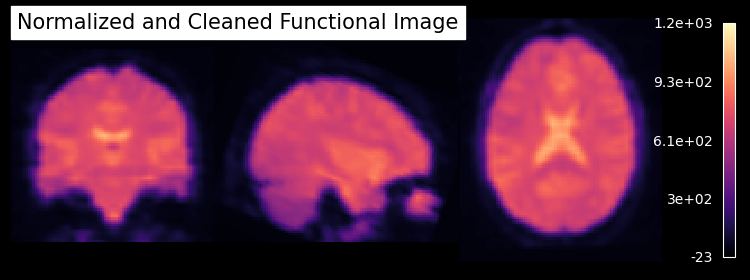

In [4]:
input_file = "../individual/output/datasink/preproc_wf/sub-02/task-flanker/sub-02_task-flanker_run-1_bold_warp.nii"

img_func = nb.load(input_file)
plotting.plot_anat(img_func.slicer[..., 0], dim='auto', draw_cross=False, annotate=False,
          cmap='magma', vmax=1250, cut_coords=[33, -20, 20], colorbar=True,
          title='Normalized and Cleaned Functional Image')

## 1.1 Signal time-course of a voxel 

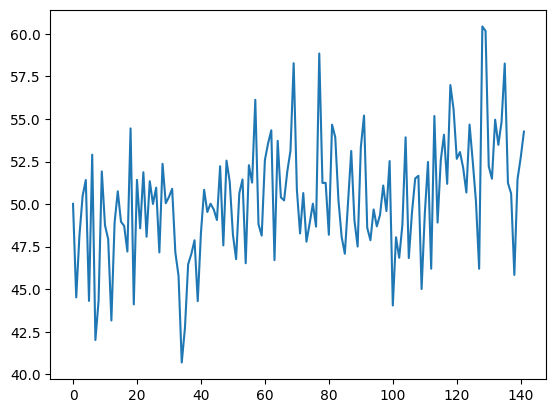

In [5]:
plot(img_func.get_fdata()[19, 16, 17, :])

To be able to do some machine learning on this data we therefore need to remove the linear trend and ideally zscore the data.

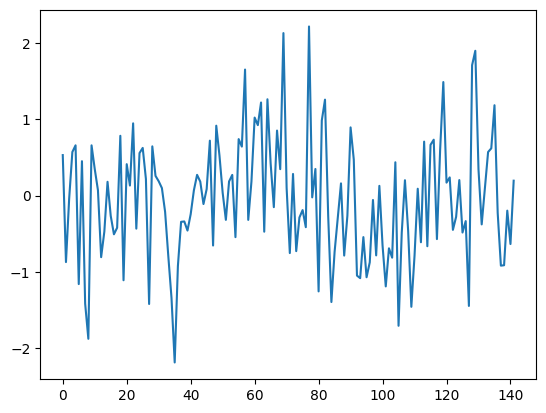

In [6]:
# Detrend and zscore the data
data = img_func.get_fdata()
data = detrend(data)
data = np.nan_to_num(zscore(data, axis=0))

# Plot the cleaned signal
plot(data[19, 16, 17, :]);

## 1.2 How many nonzero voxels do we have?

 It doesn’t make sense that we run machine learning outside of the brain.

In [7]:
img_func.get_fdata().shape

(91, 109, 91, 142)

In [8]:
np.sum(img_func.get_fdata().mean(axis=-1)!=0)

777362

So let’s use a mask to only keep those voxels that we’re interested in. For this purpose we will use the MNI-152 template brain mask and an eye mask.

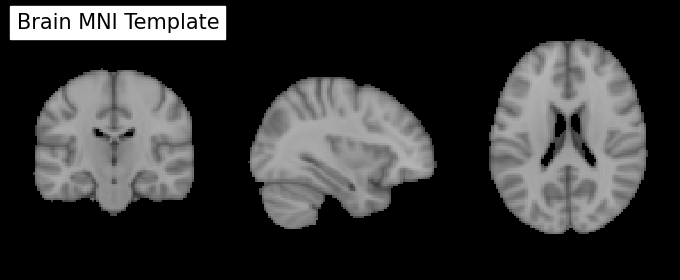

In [12]:
# Plot the region-of-interest (ROI) template
plotting.plot_anat(mni_template, dim='auto', draw_cross=False, annotate=False,
          cut_coords=[33, -20, 20], title='Brain MNI Template')

Great, now we just need to binarize this template to get a mask, dilate this mask a bit to be sure that we keep all relevant voxels and multiply it with the functional image. But before we can do any of this we also need to resample the ROI template to the same voxel resolution as the functional images.

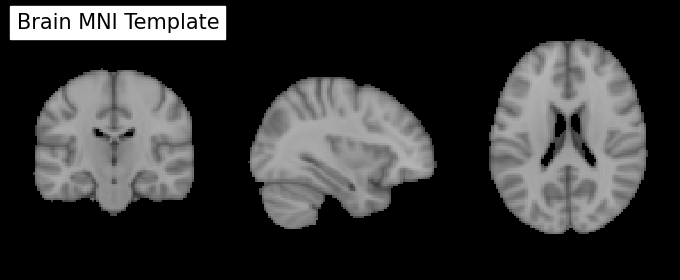

In [13]:
# Resample ROI template to functional image resolution

img_resampled = image.resample_to_img(mni_template, img_func)

plotting.plot_anat(img_resampled, dim='auto', draw_cross=False, annotate=False,
          cut_coords=[33, -20, 20], title='Brain MNI Template')

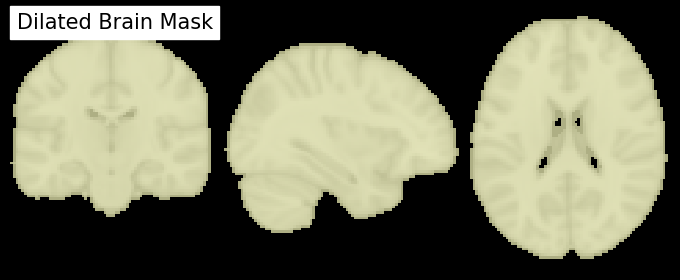

In [14]:
# Binarize ROI template
data_binary = np.array(img_resampled.get_fdata()>=10, dtype=np.int8)

# Dilate binary mask once
data_dilated = binary_dilation(data_binary, iterations=1).astype(np.int8)

# Save binary mask in NIfTI image
img_mask = nb.Nifti1Image(data_dilated, img_resampled.affine, img_resampled.header)
img_mask.set_data_dtype('i1')

# Plot binary mask (overlayed over MNI-152_Template)
plotting.plot_roi(img_mask, draw_cross=False, annotate=False, black_bg=True,
         bg_img=mni_template, cut_coords=[33, -20, 20],
         title='Dilated Brain Mask', cmap='magma_r', dim=1)

Cool. How many voxels do we have now?

In [15]:
np.sum(img_mask.get_fdata())

247661.0

Before

In [16]:
np.sum(img_func.get_fdata().mean(axis=-1)!=0)

777362

In [17]:
247661.0/777362

0.31859159567871853

That's a 69% reduction of datapoints that we need to consider in our machine-learning approach!

Now we only have to multiply this mask with our functional images and remove tailing zeros from the 3D matrix.

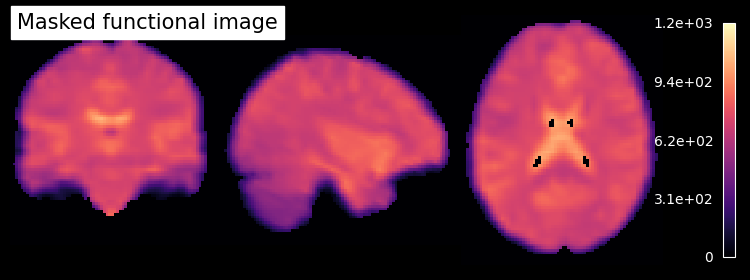

In [18]:
# Multiply the functional image with the mask
img_cleaned = image.math_img('img1 * img2', img1=img_func, img2=img_mask.slicer[..., None])

# Remove as many zero rows in the data matrix to reduce overall volume size
img_crop = image.crop_img(img_cleaned)
 
plotting.plot_anat(img_crop.slicer[..., 0], dim='auto', draw_cross=False, annotate=False,
          cmap='magma', vmax=1250, cut_coords=[33, -20, 20], colorbar=True,
          title='Masked functional image')

## 1.3 All the above in one go

In [19]:
# Load functional image
img_func = nb.load(input_file)

# Detrend and zscore data and save it under a new NIfTI file
data = img_func.get_fdata()
data = detrend(data)
data = np.nan_to_num(zscore(data, axis=0))
img_standardized = nb.Nifti1Image(data, img_func.affine, img_func.header)

img_resampled = image.resample_to_img(mni_template, img_func)
data_binary = np.array(img_resampled.get_fdata()>=10, dtype=np.int8)
data_dilated = binary_dilation(data_binary, iterations=1).astype(np.int8)
img_mask = nb.Nifti1Image(data_dilated, img_resampled.affine, img_resampled.header)
img_mask.set_data_dtype('i1')

# Multiply functional image with mask and crop image
img_cleaned = image.math_img('img1 * img2',
                       img1=img_standardized, img2=img_mask.slicer[..., None])
img_crop = image.crop_img(img_cleaned)

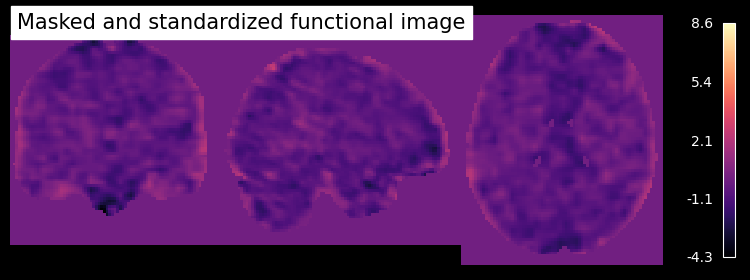

In [21]:
plotting.plot_anat(img_crop.slicer[..., 0], dim='auto', draw_cross=False, annotate=False,
          cmap='magma', cut_coords=[33, -20, 20], colorbar=True,
          title='Masked and standardized functional image')

## 1.4 Creating the machine learning dataset

Above we showed you how to prepare the data of an individual run for machine-learning. We now could use the 100 volumes per run and try to do machine learning on this. But this might not be the best approach.

Let’s consider again what we want to do. We want to predict if a person has their eyes closed or open during a resting state scan. Our assumption is that during the eyes open there is more eye movement, more visual stimulation, i.e. more variance in certain regions. Therefore, we want to look at the standard deviation over time (i.e. over the 100 volumes per run).

Keep in mind that this approach is more or less “randomly” chosen by us to be appropriate for this particular classification and might differ a lot to other datasets, research questions etc.

To nonetheless keep enough data points, let’s take the 100 volumes, and compute the standard deviation for 4 equally long sections:

In [22]:
img_std1 = nb.Nifti1Image(img_crop.get_fdata()[...,0:25].std(axis=-1), img_crop.affine, img_crop.header)
img_std2 = nb.Nifti1Image(img_crop.get_fdata()[...,25:50].std(axis=-1), img_crop.affine, img_crop.header)
img_std3 = nb.Nifti1Image(img_crop.get_fdata()[...,50:75].std(axis=-1), img_crop.affine, img_crop.header)
img_std4 = nb.Nifti1Image(img_crop.get_fdata()[...,75:100].std(axis=-1), img_crop.affine, img_crop.header)

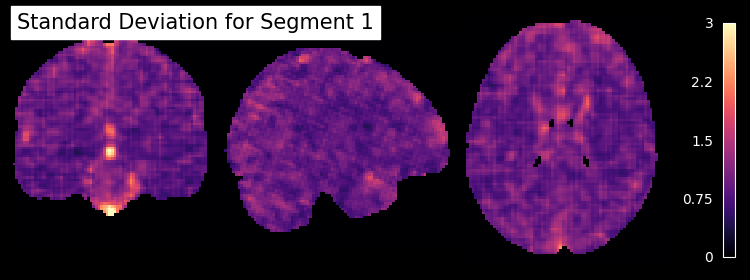

In [23]:
plotting.plot_anat(img_std1, draw_cross=False, annotate=False, cmap='magma',
          cut_coords=[33, -20, 20], vmax=3, colorbar=True,
          title='Standard Deviation for Segment 1')

If we do this now for each of the conditions run, for each of the n subjects in the dataset, we will get 4 segments x k conditions x n subjects = ___ datapoints per voxel. The pre-processing of all n subjects would explode the scope of this workshop, we therefore already pre-processed all subjects and prepared the data for the machine-learning approach: /home/neuro/workshop/notebooks/data/dataset_ML.nii.gz

# 2 MVPA

In [2]:
func = '/home/neuro/workshop/notebooks/data/dataset_ML.nii.gz'
!nib-ls $func

/home/neuro/workshop/notebooks/data/dataset_ML.nii.gz failed

